***
###### Setup

Start off by importing the necessary libraries and tools.

In [1]:
import pandas # reading/maniuplating CSV files
import nltk # preprocessing
import spacy # preprocessing
import en_core_web_sm
import gensim # Latent Dirichlet Allocation
from pprint import pprint # pretty print

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

# analysis tools
import collections
import numpy as np

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

Define constants.

In [2]:
NUM_TOPICS = 8
ALPHA = 0.1
BETA = 10

Initialize spacy 'en' model.

In [34]:
nlp = en_core_web_sm.load(disable=['parser', 'ner']) # keeping only tagger component for efficiency

***
###### Data Compilation

Load the relevant meta and text data of the active grants, while extracting the relevant data rows.

In [35]:
awardedNINR19 = pandas.read_excel(r"./../data/awarded-grants-NINR-2019.xlsx")
print(awardedNINR19.head)

<bound method NDFrame.head of      Type Actv        Project                         PI Name %tile Score  \
0       1  F31  NR018362-01A1             PIASECKI, REBECCA J     -    18   
1       1  F31  NR018363-01A1               NOWAK, ALEXANDRA      -    22   
2       1  F31  NR018369-01A1                THUL, TAYLOR ANN     -    23   
3       1  F31  NR018373-01A1  MENDEZ, KYRA JENNIFER WALIGORA     -    20   
4       1  F31  NR018574-01A1                VARTY, MAUREEN M     -    25   
..    ...  ...            ...                             ...   ...   ...   
366     5  T32    NR016914-03                TITLER, MARITA G     -    20   
367     5  T32    NR016920-03         MIASKOWSKI, CHRISTINE A     -    20   
368     5  U2C    NR014637-07                  KUTNER, JEAN S     -    30   
369     7  R01    NR014846-04                    DONG, XINQI     12    23   
370     7  R01    NR016957-02                DOWNS, CHARLES A    19    29   

                                             

Remove empty texts.

In [36]:
#awardedNINR19 = awardedNINR19[pandas.notna(awardedNINR19['Abstract Text (only)'])] # remove if abstract is empty
awardedNINR19 = awardedNINR19[awardedNINR19['Abstract Text (only)'] != "-"] # remove rows with abstracts that have dashes
print(awardedNINR19['Abstract Text (only)'][0:5])

0    PROPOSAL SUMMARY Over 200,000 patients experie...
1    Project Summary/Abstract African American wome...
2    PROJECT SUMMARY Background: Synthetic oxytocin...
3    Project Summary An estimated 80% of the 5.4 to...
4    Project Summary / Abstract Transition from ped...
Name: Abstract Text (only), dtype: object


Concatenate columns 'T', 'A', 'N', and 'S' to form long strings for each application, representing the document.

In [37]:
awardedNINR19['text'] = awardedNINR19['Title'].map(str) + " " + awardedNINR19['Abstract Text (only)'].map(str) + " " + awardedNINR19['SA Text'].map(str)
awardedNINR19 = awardedNINR19[pandas.notna(awardedNINR19['text'])]

Remove unnecessary columns.

In [38]:
awardedNINR19 = awardedNINR19.drop(columns = ['Title', 'Abstract Text (only)', 'SA Text']) 

In [39]:
awardedNINR19.head()

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,Medical emergency team trigger clusters: Descr...
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,Neighborhood Disorder and Epigenetic Regulatio...
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,Evaluating the Contribution of Synthetic Oxyto...
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,Dementia informal caregivers mobile app use an...
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,Factors Predicting Transition Readiness in You...


***
###### Text Preprocessing

Clean up the text by stripping whitespace and keeping only letters.

In [40]:
awardedNINR19['text'] = awardedNINR19['text'].str.replace("\n", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("\r", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("-", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("'", "")

awardedNINR19['text'] = awardedNINR19['text'].str.replace("[^abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 ]", " ") 

awardedNINR19['text'] = awardedNINR19['text'].str.lower() 

awardedNINR19['text'] = awardedNINR19['text'].str.replace("abstract", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("project", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("proposal", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("summary", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("narrative", " ") 
awardedNINR19['text'] = awardedNINR19['text'].str.replace("background", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("supplement", " ") 
awardedNINR19['text'] = awardedNINR19['text'].str.replace("significance", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("overall", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("title", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("specific aims", " ") 
awardedNINR19['text'] = awardedNINR19['text'].str.replace("goal", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("research plan", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("overview", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("\\s+", " ")
awardedNINR19['text'] = awardedNINR19['text'].str.replace("description provided by applicant", " ") 

awardedNINR19['text'] = awardedNINR19['text'].str.strip()

Only keep documents with unique text.

In [41]:
print(len(awardedNINR19.index))
awardedNINR_new = awardedNINR19.drop_duplicates(subset=['text'])
print(len(awardedNINR_new.index))

369
362


Load stopwords (http://www.ai.mit.edu/projects/jmlr/papers/volume5/lewis04a/a11-smart-stop-list/english.stop) and our own collection of words to remove.

In [42]:
with open("stopwords_smart.txt") as f: # words loaded from local .txt file
    remove_words = [line.strip() for line in f if line.strip()]
    
remove_words = [t.replace("'", "") for t in remove_words]
print(remove_words)

['STOPWORDS', 'a', 'as', 'able', 'about', 'above', 'according', 'accordingly', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'aint', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', 'arent', 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', 'cmon', 'cs', 'came', 'can', 'cant', 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing',

Split the texts into lists of words. Also check against stopwords of the word's stem and remove. Here we apply Snowball Stemming (http://snowball.tartarus.org/texts/introduction.html).

In [43]:
sno = nltk.stem.SnowballStemmer('english') # import from nltk library

In [44]:
def stem_sentences(text): # helper function
    tokens = text.split()
    split_text = [t for t in tokens if sno.stem(t) not in remove_words]
    return(split_text)

In [45]:
awardedNINR19['text'] = awardedNINR19['text'].apply(stem_sentences) # apply function for each document

In [47]:
awardedNINR19.head(20)

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,"[medical, emergency, team, trigger, clusters, ..."
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,"[neighborhood, disorder, epigenetic, regulatio..."
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,"[evaluating, contribution, synthetic, oxytocin..."
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,"[dementia, informal, caregivers, mobile, app, ..."
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,"[factors, predicting, transition, readiness, y..."
5,1,F31,NR018576-01A1,"LEBLANC, MATTHEW ROGER",-,14,201905,"BANKS, DAVID",DTRPC,PA18-671,Awarded. Fellowships only,2019,"[advanced, symptom, burden, quality, life, mul..."
6,1,F31,NR018580-01A1,"SHAW, CLARISSA ANNE",-,20,201905,"BANKS, DAVID",DTRRC,PA18-671,Awarded. Fellowships only,2019,"[resistiveness, dementia, nurse, communication..."
7,1,F31,NR018582-01,"KISSLER, KATHERINE",-,23,201901,"BANKS, DAVID",DTRWH,PA18-671,Awarded. Fellowships only,2019,"[classification, labor, dystocia, developing, ..."
8,1,F31,NR018586-01,"KALVAS, LAURA BETH ANN",-,23,201901,"BANKS, DAVID",DTRDP,PA18-671,Awarded. Fellowships only,2019,"[sleep, disruption, delirium, critically, chil..."
9,1,F31,NR018588-01,"VASBINDER, ALEXI L",-,19,201901,"BANKS, DAVID",DTRWH,PA18-671,Awarded. Fellowships only,2019,"[biomarkers, long, term, fatigue, breast, canc..."


***
Build a bigram model of the texts.

In [48]:
texts = awardedNINR19.text.values.tolist() # creates text_values variable
print(texts[0])

['medical', 'emergency', 'team', 'trigger', 'clusters', 'describing', 'symptom', 'experience', 'during', 'clinical', 'deterioration', 'context', 'medical', 'emergency', 'team', 'care', '200', '000', 'patients', 'experience', 'hospital', 'cardiac', 'arrests', 'ihcas', 'annually', 'only', '17', 'survive', 'discharge', 'medical', 'emergency', 'teams', 'mets', 'teams', 'clinicians', 'work', 'improve', 'adverse', 'patient', 'outcomes', 'ihca', 'hospital', 'mortality', 'providing', 'early', 'detection', 'rapid', 'interventions', 'clinically', 'deteriorating', 'patients', 'mets', 'decrease', 'ihca', '38', 'impact', 'patient', 'outcomes', 'remains', 'inconclusive', 'met', 'triggers', 'signs', 'symptoms', 'clinical', 'deterioration', 'result', 'met', 'activation', 'related', 'symptom', 'experience', 'clinical', 'deterioration', 'provide', 'additional', 'insight', 'multiple', 'met', 'triggers', 'commonly', 'occur', 'adult', 'pediatric', 'met', 'events', 'presence', 'multiple', 'met', 'triggers',

In [49]:
bigram_phrases = gensim.models.Phrases(texts, min_count=5, threshold=100)
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)

In [50]:
bigrams = [bigram_phraser[doc] for doc in texts] # form bigrams
print(bigrams[0])

['medical', 'emergency', 'team', 'trigger_clusters', 'describing', 'symptom', 'experience', 'during', 'clinical', 'deterioration', 'context', 'medical', 'emergency', 'team', 'care', '200', '000', 'patients', 'experience', 'hospital', 'cardiac', 'arrests', 'ihcas', 'annually', 'only', '17', 'survive', 'discharge', 'medical', 'emergency', 'teams', 'mets', 'teams', 'clinicians', 'work', 'improve', 'adverse', 'patient', 'outcomes', 'ihca', 'hospital', 'mortality', 'providing', 'early', 'detection', 'rapid', 'interventions', 'clinically', 'deteriorating', 'patients', 'mets', 'decrease', 'ihca', '38', 'impact', 'patient', 'outcomes', 'remains', 'inconclusive', 'met_triggers', 'signs', 'symptoms', 'clinical', 'deterioration', 'result', 'met', 'activation', 'related', 'symptom', 'experience', 'clinical', 'deterioration', 'provide', 'additional', 'insight', 'multiple', 'met_triggers', 'commonly', 'occur', 'adult', 'pediatric', 'met_events', 'presence', 'multiple', 'met_triggers', 'associated', 

Lemmatize the words of the text, while only including nouns and verbs.

In [52]:
def lemmatization(texts, allowed_postags=['NOUN', 'VERB']): # helper fuction
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) # spacy function
        texts_out.append([token.lemma_ for token in doc]) #if token.pos_ in allowed_postags]) # This gets rid of many things
    return(texts_out)

In [53]:
#texts = lemmatization(bigrams)
texts = bigrams

In [54]:
#remove_words = []
#with open("lemma_stopwords.txt") as f: # words loaded from local .txt file
#    remove_words = [line.strip() for line in f if line.strip()]

#for i in range(len(texts)):
#    for remove_word in remove_words:
#        if remove_word in texts[i]:
#            texts[i] = list(filter(lambda a: a != remove_word, texts[i]))
    
#texts[1][0:5]

***
###### Latent Dirichlet Allocation

Build a dictionary and corpus for use with LDA.

In [55]:
dictionary = gensim.corpora.Dictionary(texts)
print(dictionary)

Dictionary(13318 unique tokens: ['000', '075', '1', '11', '12']...)


In [68]:
corpus = [dictionary.doc2bow(text) for text in texts] # text is list of bigrams
print(len(corpus[5]))

#new_corpus = []
#for text in corpus:
#    doc_words = []
#    for tuple in text:
#        if (tuple[1] >= 10):
#            doc_words.append(tuple)
#    new_corpus.append(doc_words)

#corpus = new_corpus
#print(len(corpus[5]))
#print(corpus)
            

377


Convert the next cell to code to run the optimization algorithm. This may take hours, depending on your machine.

In [ ]:
lst = []
for t in [3, 4, 5, 6, 7, 8]: 
    for i in [0.05, 0.1, 0.5, 1, 5]: 
        for j in [0.05, 0.1, 0.5, 1, 5]: 
            param_list = []
            lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=t, id2word=dictionary, random_state=100, update_every=1, 
                                               chunksize=20, passes=10, alpha=i, eta=j, iterations=1000, per_word_topics=True) 
            print("N: " + str(t) + " ... Alpha: " + str(i) + " ... Beta: " + str(j)) 
            print(" -> Perplexity = ", lda_model.log_perplexity(corpus)) 
            coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v') 
            coherence_lda = coherence_model_lda.get_coherence() 
            print(" -> Coherence Score = ", coherence_lda) 
            
            param_list.append(t)
            param_list.append(i)
            param_list.append(j)
            param_list.append(coherence_lda)
            param_list.append(lda_model.log_perplexity(corpus))
            lst.append(param_list)
                                  
lda_param = pandas.DataFrame(lst, columns = ['Topic', 'Alpha', 'Beta', 'Coherence', 'Perplexity'])       
lda_param.to_csv('LDA_Param.csv')

N: 3 ... Alpha: 0.05 ... Beta: 0.05
 -> Perplexity =  -13.576749894357336
 -> Coherence Score =  0.3125060980393198
N: 3 ... Alpha: 0.05 ... Beta: 0.1
 -> Perplexity =  -8.671581737680292
 -> Coherence Score =  0.31301018624712185
N: 3 ... Alpha: 0.05 ... Beta: 0.5
 -> Perplexity =  -7.9218776773444795
 -> Coherence Score =  0.2997437485665105
N: 3 ... Alpha: 0.05 ... Beta: 1
 -> Perplexity =  -7.970620841180002
 -> Coherence Score =  0.3027121828908425
N: 3 ... Alpha: 0.05 ... Beta: 5
 -> Perplexity =  -8.156525605418512
 -> Coherence Score =  0.3280580808749635
N: 3 ... Alpha: 0.1 ... Beta: 0.05
 -> Perplexity =  -13.573340193475712
 -> Coherence Score =  0.31143767243261805
N: 3 ... Alpha: 0.1 ... Beta: 0.1
 -> Perplexity =  -8.667734577345664
 -> Coherence Score =  0.31149282449834115
N: 3 ... Alpha: 0.1 ... Beta: 0.5
 -> Perplexity =  -7.921585080403218
 -> Coherence Score =  0.29328081957827695
N: 3 ... Alpha: 0.1 ... Beta: 1
 -> Perplexity =  -7.971166109670379
 -> Coherence Sco

N: 5 ... Alpha: 5 ... Beta: 1
 -> Perplexity =  -8.026651152305803
 -> Coherence Score =  0.3879914305264058
N: 5 ... Alpha: 5 ... Beta: 5
 -> Perplexity =  -8.237755853207284
 -> Coherence Score =  0.43796565081129557
N: 6 ... Alpha: 0.05 ... Beta: 0.05
 -> Perplexity =  -13.410403223091874
 -> Coherence Score =  0.3686968391591117
N: 6 ... Alpha: 0.05 ... Beta: 0.1
 -> Perplexity =  -8.519224568950708
 -> Coherence Score =  0.33997815903238576
N: 6 ... Alpha: 0.05 ... Beta: 0.5
 -> Perplexity =  -7.910172537762517
 -> Coherence Score =  0.3645778762051972
N: 6 ... Alpha: 0.05 ... Beta: 1
 -> Perplexity =  -7.965204971549928
 -> Coherence Score =  0.39149770086300467
N: 6 ... Alpha: 0.05 ... Beta: 5
 -> Perplexity =  -8.158713462572187
 -> Coherence Score =  0.4893383618096471
N: 6 ... Alpha: 0.1 ... Beta: 0.05
 -> Perplexity =  -13.407234456273178
 -> Coherence Score =  0.3636643722934932
N: 6 ... Alpha: 0.1 ... Beta: 0.1
 -> Perplexity =  -8.516527011394905
 -> Coherence Score =  0.

We see that the "best" model according to lowest perplexity and highest coherence scores is a model with parameters N = 3, Alpha = 0.05, and Beta = 0.05.

Build the LDA model.

In [69]:
lda_model = gensim.models.LdaModel(corpus=corpus,
                                    num_topics=8,
                                    id2word=dictionary,
                                    random_state=100,
                                    update_every=1,
                                    chunksize=20,
                                    passes=10,
                                    alpha=0.1,
                                    eta=10,
                                    iterations=1000,
                                    per_word_topics=True)


Print perplexity and coherence score.

In [70]:
print("Perplexity =", lda_model.log_perplexity(corpus))

coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score =", coherence_lda)

Perplexity = -8.299193324888595
Coherence Score = 0.6217215666324712


Print top 10 words for each topic.

In [71]:
p_models = lda_model.show_topics(num_words=10, formatted=False)

In [72]:
pprint(p_models)

[(0,
  [('tracheostomy', 8.0739555e-05),
   ('trachalarm', 8.054501e-05),
   ('tracheostomy_tube', 8.054501e-05),
   ('magnetic', 7.786085e-05),
   ('tubes', 7.741471e-05),
   ('tracheotomy', 7.6954275e-05),
   ('removed', 7.6954275e-05),
   ('opening', 7.6954275e-05),
   ('alarm', 7.666486e-05),
   ('accidentally', 7.649043e-05)]),
 (1,
  [('rage', 0.00043154947),
   ('ards', 0.00041402),
   ('signaling_proteins', 0.00030598135),
   ('curcumin', 0.00030598135),
   ('sg_critical', 0.00028748743),
   ('lung_fluid', 0.00026885164),
   ('alveolar', 0.0002500727),
   ('sg', 0.00023114934),
   ('gsh', 0.00023114934),
   ('comt', 0.00022917453)]),
 (2,
  [('solidarity', 7.508647e-05),
   ('chinese_older', 7.508645e-05),
   ('rage', 7.5086435e-05),
   ('ards', 7.5086435e-05),
   ('postdoctoral_trainees', 7.508643e-05),
   ('trainees', 7.508642e-05),
   ('nurse_scientists', 7.508642e-05),
   ('ucsf', 7.508642e-05),
   ('predoctoral', 7.508641e-05),
   ('dts', 7.508641e-05)]),
 (3,
  [('solidar

***
###### Analysis

Add a column to the data frame that specifies the topic most likely to be associated to that row's document.

In [56]:
probable_topics = []

for index, row in awardedNINR19.iterrows():
    bow = dictionary.doc2bow(row['text'])
    t = lda_model.get_document_topics(bow)
    
    probs = [tple for tple in t]
    print(probs)
    max_tple = max(probs, key=lambda x:x[1])
    print(max_tple)
    probable_topics.append(max_tple[0])

awardedNINR19['topic'] = probable_topics

[(0, 0.90765935), (1, 0.08486129)]
(0, 0.90765935)
[(0, 0.07926149), (1, 0.91285634)]
(1, 0.91285634)
[(0, 0.069475345), (1, 0.9165773), (2, 0.013947384)]
(1, 0.9165773)
[(0, 0.56398517), (1, 0.38538843), (2, 0.05062642)]
(0, 0.56398517)
[(0, 0.7382855), (1, 0.25934914)]
(0, 0.7382855)
[(0, 0.8455604), (1, 0.14834534)]
(0, 0.8455604)
[(0, 0.31443176), (1, 0.5459925), (2, 0.13957575)]
(1, 0.5459925)
[(0, 0.57344514), (1, 0.42444688)]
(0, 0.57344514)
[(0, 0.18843584), (1, 0.69845194), (2, 0.11311224)]
(1, 0.69845194)
[(0, 0.7905674), (1, 0.2010119)]
(0, 0.7905674)
[(0, 0.9444294), (1, 0.05546879)]
(0, 0.9444294)
[(0, 0.12390125), (1, 0.875988)]
(1, 0.875988)
[(0, 0.29371077), (1, 0.6396111), (2, 0.06667812)]
(1, 0.6396111)
[(0, 0.7821487), (1, 0.21462482)]
(0, 0.7821487)
[(0, 0.64351463), (1, 0.3563759)]
(0, 0.64351463)
[(0, 0.19589326), (1, 0.7995766)]
(1, 0.7995766)
[(0, 0.13004215), (1, 0.86043394)]
(1, 0.86043394)
[(0, 0.3010556), (1, 0.6988337)]
(1, 0.6988337)
[(0, 0.22647554), (1, 

[(0, 0.5163963), (1, 0.47530836)]
(0, 0.5163963)
[(0, 0.41503868), (1, 0.36470765), (2, 0.22025368)]
(0, 0.41503868)
[(0, 0.5856673), (1, 0.40916082)]
(0, 0.5856673)
[(0, 0.12077641), (1, 0.85504633), (2, 0.024177257)]
(1, 0.85504633)
[(0, 0.29488462), (1, 0.69219875), (2, 0.012916607)]
(1, 0.69219875)
[(0, 0.29013214), (1, 0.49122617), (2, 0.21864173)]
(1, 0.49122617)
[(0, 0.24574533), (1, 0.4878989), (2, 0.2663558)]
(1, 0.4878989)
[(0, 0.7703243), (1, 0.21294093), (2, 0.016734771)]
(0, 0.7703243)
[(0, 0.46259245), (1, 0.5322849)]
(1, 0.5322849)
[(0, 0.2930104), (1, 0.7001398)]
(1, 0.7001398)
[(0, 0.7283022), (1, 0.27148414)]
(0, 0.7283022)
[(0, 0.7484277), (1, 0.2402953), (2, 0.011277035)]
(0, 0.7484277)
[(0, 0.63456345), (1, 0.3547775), (2, 0.010659029)]
(0, 0.63456345)
[(0, 0.5639355), (1, 0.42943755)]
(0, 0.5639355)
[(0, 0.8021855), (1, 0.18938246)]
(0, 0.8021855)
[(0, 0.6087304), (1, 0.39115363)]
(0, 0.6087304)
[(0, 0.59990543), (1, 0.27510428), (2, 0.124990255)]
(0, 0.59990543)


In [57]:
awardedNINR19.head()

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text,topic
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,"[medical, emergency, team, trigger, clusters, ...",0
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,"[neighborhood, disorder, epigenetic, regulatio...",1
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,"[evaluating, contribution, synthetic, oxytocin...",1
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,"[dementia, informal, caregivers, mobile, app, ...",0
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,"[factors, predicting, transition, readiness, y...",0


POs on x-axis, # of grants on y-axis. Stacked bar graph.

In [67]:
po_dict = collections.defaultdict(list)

for index, row in awardedNINR19.iterrows():
    po = row['PO Name']
    topic = row['topic']
    po_dict[po].append(topic)

for key, value in po_dict.items():
    print(key + ": " + str(len(value)))

BANKS, DAVID: 57
TULLY, LOIS: 61
HAMLET, MICHELLE R: 36
ADAMS, LYNN S: 32
HUSS, KAREN: 39
HENRY, REBECCA: 26
YOON, SUNG SUG: 36
MATOCHA, MARTHA F.: 11
RASOOLY, REBEKAH S: 12
BOUGH, KRISTOPHER J.: 27
KEHL, KAREN: 26


Sum up topic counts for each PO.

In [68]:
data_dict = collections.defaultdict(list)

for key, value in po_dict.items():
    c = collections.Counter(po_dict[key])
    
    for i in range(NUM_TOPICS):
        data_dict[key].append(c[i])

In [69]:
PO = []
t = []
n = []

for key, value in data_dict.items():
    for i in range(NUM_TOPICS):
        PO.append(key)
        t.append(i)
        n.append(value[i])

In [70]:
data = [PO, t, n]
PO_header = list(set(PO))

In [71]:
rows = np.array(data).T.tolist()
headers = ['Program Officials', 'Topic', '#']
df = pandas.DataFrame(rows, columns = headers)

df.head()
df.dtypes

Program Officials    object
Topic                object
#                    object
dtype: object

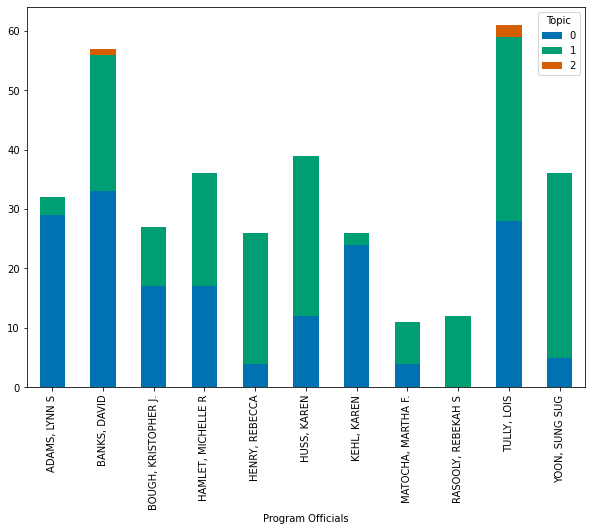

In [73]:
pivot_df = df.pivot(index='Program Officials', columns='Topic', values='#')

for i in range(NUM_TOPICS):
    pivot_df.iloc[:, i] = pandas.to_numeric(pivot_df.iloc[:, i])

pivot_df.plot.bar(stacked=True, figsize=(10,7))

***
###### Topic Visualizations

t-SNE Implementation

In [87]:
# Filter by PO
po_dict = {"ADAMS, LYNN S": 0, "BANKS, DAVID": 1, "BOUGH, KRISTOPHER J.": 2, "HAMLET, MICHELLE R": 3,
           "HENRY, REBECCA" : 4, "HUSS, KAREN" : 5, "KEHL, KAREN" : 6, "MATOCHA, MARTHA F." : 7, 
           "RASOOLY, REBEKAH S" : 8, "TULLY, LOIS" : 9, "YOON, SUNG SUG" : 10}

po_num = []
for index, row in awardedNINR19.iterrows():
    po_num.append(po_dict[row['PO Name']])

print(len(po_num))

363


In [88]:
# filtering by topics
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
arr = pandas.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0] # adjust threshold
topic_num = np.argmax(arr, axis=1)

print(len(topic_num))

363


In [105]:
# build graph
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
output_notebook()
n_topics = NUM_TOPICS
mycolors = np.array([color for name, color in mcolors.CSS4_COLORS.items()])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 363 samples in 0.001s...
[t-SNE] Computed neighbors for 363 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 363 / 363
[t-SNE] Mean sigma: 0.039532
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.470261
[t-SNE] KL divergence after 1000 iterations: 0.190174


Loading BokehJS ...

In [109]:
# plot graph for topic filters
plot = figure(title="t-SNE Clustering of LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

# plot graph for po filters
plot = figure(title="t-SNE Clustering of Program Officials".format(n_topics), 
              plot_width=900, plot_height=700)


plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[po_num])
show(plot)

pyLDAvis

In [110]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.118238  0.185470       1        1  52.112610
0     -0.214135 -0.152925       2        1  44.956242
2      0.332373 -0.032545       3        1   2.931146, topic_info=              Term         Freq        Total Category  logprob  loglift
151        patient  3134.000000  3134.000000  Default  30.0000  30.0000
107        improve  1947.000000  1947.000000  Default  29.0000  29.0000
9            adult  1017.000000  1017.000000  Default  28.0000  28.0000
1350         sleep   575.000000   575.000000  Default  27.0000  27.0000
32            care  3369.000000  3369.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
626    application    49.652264   528.238647   Topic3  -4.8863   1.1653
505   longitudinal    46.831173   427.097504   Topic3  -4.9448   1.3193
52         control    48.570724   880.776184   Topic3  -4.9084   0.6320
80         examine    47.858273   870.952820   Topic3  -4.9231   0.6284
119   intervention    48.624439  3690.909180   Topic3  -4.9073  -0.7997

[198 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1288      3  0.992801      actigraphy
1020      1  0.494200        activity
1020      2  0.274360        activity
1020      3  0.230392        activity
748       1  1.000560      adolescent
...     ...       ...             ...
391       2  0.095110            week
1457      2  1.000547          weight
394       1  0.999842           woman
1361      3  0.991395  working_memory
881       1  1.000210           youth

[248 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

***
###### Word Vectors

In [111]:
awardedNINR19['processed_text'] = texts

In [112]:
awardedNINR19.head()

,Type,Actv,Project,PI Name,%tile,Score,Council,PO Name,PCC,RFA/PA Number,Stat Desc,FY,text,topic,processed_text
0,1,F31,NR018362-01A1,"PIASECKI, REBECCA J",-,18,201905,"BANKS, DAVID",DTRSC,PA18-671,Awarded. Fellowships only,2019,"[medical, emergency, team, trigger, clusters, ...",0,"[medical, emergency, team, trigger_cluster, de..."
1,1,F31,NR018363-01A1,"NOWAK, ALEXANDRA",-,22,201901,"BANKS, DAVID",DTRHD,PA18-671,Awarded. Fellowships only,2019,"[neighborhood, disorder, epigenetic, regulatio...",1,"[neighborhood_disorder, epigenetic, regulation..."
2,1,F31,NR018369-01A1,"THUL, TAYLOR ANN",-,23,201905,"BANKS, DAVID",DTRSS,PA18-671,Awarded. Fellowships only,2019,"[evaluating, contribution, synthetic, oxytocin...",1,"[evaluate, contribution, synthetic_oxytocin, e..."
3,1,F31,NR018373-01A1,"MENDEZ, KYRA JENNIFER WALIGORA",-,20,201905,"BANKS, DAVID",DTRCG,PA18-671,Awarded. Fellowships only,2019,"[dementia, informal, caregivers, mobile, app, ...",0,"[dementia, informal, caregiver, mobile_app, in..."
4,1,F31,NR018574-01A1,"VARTY, MAUREEN M",-,25,201910,"BANKS, DAVID",DTRCC,PA19-195,Awarded. Fellowships only,2019,"[factors, predicting, transition, readiness, y...",0,"[factor, predict, transition_readiness, youth,..."


In [208]:
topics_list = []
for t in lda_model.show_topics(num_words=10, formatted=False):
    print(t[1])
    t_list = []
    for w in t[1]:
        t_list.append(w)
    topics_list.append(t_list)
    
print(topics_list)
print(len(topics_list))

[('care', 0.031236902), ('patient', 0.031070033), ('symptom', 0.018085217), ('pain', 0.01774048), ('chronic', 0.014125408), ('treatment', 0.013347073), ('clinical', 0.013052865), ('caregiver', 0.012561714), ('improve', 0.011663784), ('outcome', 0.010677945)]
[('intervention', 0.025520476), ('health', 0.02086713), ('increase', 0.012930789), ('risk', 0.010914601), ('group', 0.01011802), ('behavior', 0.009347185), ('child', 0.009279353), ('level', 0.008479004), ('high', 0.008471736), ('effect', 0.007940538)]
[('sleep', 0.08742473), ('cognitive_impairment', 0.08084694), ('cognitive', 0.04555913), ('quantify', 0.033102527), ('older_adult', 0.028238608), ('dementia', 0.02571844), ('function', 0.024814049), ('adult', 0.021819962), ('sleep_deficiency', 0.020669077), ('icu', 0.01999117)]
[[('care', 0.031236902), ('patient', 0.031070033), ('symptom', 0.018085217), ('pain', 0.01774048), ('chronic', 0.014125408), ('treatment', 0.013347073), ('clinical', 0.013052865), ('caregiver', 0.012561714), ('

In [214]:
topics = []
for i in range(NUM_TOPICS):
    topics.append([])

for index, row in awardedNINR19.iterrows():
    topic = row['topic']
    topics[topic].append(row['processed_text'])
    
print(topics) #list of NUM lists, and each of NUM lists consists of multiple processed test lists where NUM is 3 for example

[[['medical', 'emergency', 'team', 'trigger_cluster', 'describe', 'symptom', 'experience', 'during', 'clinical', 'deterioration', 'context', 'medical', 'emergency', 'team', 'care', 'proposal', 'summary', 'patient', 'experience', 'inhospital', 'cardiac', 'arrest', 'ihcas', 'annually', 'only', 'survive', 'discharge', 'medical', 'emergency', 'team', 'met', 'team', 'clinician', 'work', 'improve', 'adverse', 'patient', 'outcome', 'ihca', 'hospital', 'mortality', 'provide', 'early', 'detection', 'rapid', 'intervention', 'clinically', 'deteriorate', 'patient', 'met', 'decrease', 'ihca', 'impact', 'patient', 'outcome', 'remain', 'inconclusive', 'met_triggers', 'sign', 'symptom', 'clinical', 'deterioration', 'result', 'meet', 'activation', 'relate', 'symptom', 'experience', 'clinical', 'deterioration', 'provide', 'additional', 'insight', 'multiple', 'met_triggers', 'commonly', 'cooccur', 'adult', 'pediatric', 'met_events', 'presence', 'multiple', 'met_trigger', 'associate', 'high', 'incidence',

In [220]:
from gensim.models import Word2Vec

models = []
count = 1
for t in topics: #iterates over number of topics
    #y = np.concatenate([np.array(i) for i in t])
    #print(y)
    #print(len(y))
    #print(t) # t is a list of lists, where each nested list contains words from a grant application
    if (count == 3):
        print(t)
    count += 1
    models.append(Word2Vec(t, min_count=1))
    
#print(models[0])
#print(models[1])
#print(models[2])

[['sleep', 'quality', 'cognitive', 'function', 'hospitalize', 'old', 'adult', 'survivor', 'critical', 'illness', 'project_summaryabstract', 'intensive', 'care', 'unit', 'icu', 'survivor', 'experience', 'posticu_cognitive', 'impairment', 'comparable', 'mild', 'alzheimers_disease', 'suffer', 'cognitive_impairment', 'equivalent', 'moderate', 'traumatic', 'brain_injury', 'critically_ill', 'older_adult', 'age', 'old', 'high', 'incidence', 'mechanical_ventilation', 'risk', 'posticu_cognitive', 'impairment', 'mechanically_ventilate', 'icu', 'patient', 'experience', 'bad', 'sleep', 'ventilate', 'focus', 'old', 'adult', 'icu', 'survivor', 'required_mechanical', 'ventilation', 'survival', 'scientific', 'premise', 'sleep_deficiency', 'associate', 'posticu', 'syndrome', 'cognitive_impairment', 'sleep', 'modifiable', 'risk', 'factor', 'prevent', 'posticu_cognitive', 'impairment', 'understanding', 'sleep_deficiency', 'essential', 'design', 'personalize', 'symptom', 'management', 'intervention', 'pre

Combine and format.

In [221]:
acronym_lookup = {}
acronym_lookup["pa"] = "physical activity"
acronym_lookup["smm"] = "severe maternal morbidity"
acronym_lookup["hf"] = "heart failure"
acronym_lookup["plwh"] = "persons living with HIV"
acronym_lookup["t2dm"] = "type 2 diabetes mellitus"
acronym_lookup["msm"] = "men who have sex with men"
acronym_lookup["fsw"] = "female sex worker"
acronym_lookup["hana"] = "HIV-associated non-AIDS conditions"
acronym_lookup["acp"] = "advance care planning"
acronym_lookup["cds"] = "clinical decision support"
acronym_lookup["cqa"] = "communication quality analysis"
acronym_lookup["cci"] = "chronic critical illness"
acronym_lookup["comt"] = "catechol-O-methyltransferase"
acronym_lookup["bpsd"] = "behavioral and psychological symptoms of dementia"
acronym_lookup["pwd"] = "persons with dementia"
acronym_lookup["fc"] = "fecal calprotectin"
acronym_lookup["eolpc"] = "end of life and palliative care"
acronym_lookup["pcrc"] = "Palliative Care Research Consortium"
acronym_lookup["cmc"] = "children with medical complexity"
acronym_lookup["4_bpsd"] = "behavioral and psychological symptoms of dementia"
acronym_lookup["pes"] = "patient engagement specialist"
acronym_lookup["mcc"] = "multiple chronic conditions"
acronym_lookup["hhc"] = "home healthcare"
acronym_lookup["dts"] = "disinfection tracking system"
acronym_lookup["cri"] = "cardiorespiratory instability"
acronym_lookup["vte"] = "Venous thromboembolism"
acronym_lookup["pru"] = "pruritis"
acronym_lookup["cbpr"] = "community-based participatory research"
acronym_lookup["cbt"] = "cognitive behavioral therapy"
acronym_lookup["trkb"] = "tropomyosin-related receptor kinase type B"
acronym_lookup["lbp"] = "lower back pain"
acronym_lookup["trkb_t1"] = "truncated isoform of Trkb"
acronym_lookup["oa"] = "osteoarthritis"
acronym_lookup["eol"] = "end of life"

0
('care', 0.031236902)
('patient', 0.031070033)
('symptom', 0.018085217)
('pain', 0.01774048)
('chronic', 0.014125408)
('treatment', 0.013347073)
('clinical', 0.013052865)
('caregiver', 0.012561714)
('improve', 0.011663784)
('outcome', 0.010677945)
1
('intervention', 0.025520476)
('health', 0.02086713)
('increase', 0.012930789)
('risk', 0.010914601)
('group', 0.01011802)
('behavior', 0.009347185)
('child', 0.009279353)
('level', 0.008479004)
('high', 0.008471736)
('effect', 0.007940538)
2
('sleep', 0.08742473)
('cognitive_impairment', 0.08084694)
('cognitive', 0.04555913)
('quantify', 0.033102527)
('older_adult', 0.028238608)
('dementia', 0.02571844)
('function', 0.024814049)
('adult', 0.021819962)
('sleep_deficiency', 0.020669077)
('icu', 0.01999117)


In [ ]:
combined_list = []
for t in range(len(topics_list)):
    print(t)
    sub_list = []
    for w in topics_list[t]: # w is a tuple
        if (w[0] in acronym_lookup):
            w[0] = acronym_lookup[w[0]]
        print(w)
        similars = models[t].most_similar(positive=[w[0]], topn=10)
        for sim in similars:
            if (sim in acronym_lookup):
                sim = acronym_lookup[sim]
        sub_list.append((w[0], similars))
    combined_list.append(sub_list)

In [222]:
pprint(combined_list)

[[('care',
   [('home', 0.9993621110916138),
    ('endoflife', 0.9993468523025513),
    ('hospice', 0.9993211627006531),
    ('concurrent', 0.9992685317993164),
    ('pediatric', 0.9992568492889404),
    ('transitional', 0.9992362260818481),
    ('access', 0.9991582632064819),
    ('service', 0.9991580843925476),
    ('palliative', 0.9991368651390076),
    ('child', 0.999116837978363)]),
  ('patient',
   [('great', 0.9998596906661987),
    ('report', 0.9998400211334229),
    ('rural', 0.9998352527618408),
    ('impact', 0.9998350739479065),
    ('significant', 0.9998325705528259),
    ('person', 0.999832272529602),
    ('significantly', 0.9998295903205872),
    ('rate', 0.9998284578323364),
    ('service', 0.9998224377632141),
    ('live', 0.9998167157173157)]),
  ('symptom',
   [('disability', 0.9997996687889099),
    ('reduce', 0.9997919201850891),
    ('individual', 0.999759316444397),
    ('manage', 0.9997522830963135),
    ('physical', 0.9997460842132568),
    ('severity', 0.99973